In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [25]:
import glob

# find all the pkl files
pkl_files = glob.glob('./datasets/low/*.pkl')
print(pkl_files)

['./datasets/low/episode_788308674.pkl']


In [27]:
import os
# get pkl file name
os.path.basename(pkl_files[0]).split('.')[0]

'episode_788308674'

In [9]:
# read the pickle file
with open('datasets/low/episode_788308674.pkl', 'rb') as f:
    data = pickle.load(f)
print(data.keys(), data['samples'].keys(), len(data['samples']))

dict_keys(['obj_urdf_files', 'obj_init_poses', 'obj_init_orns', 'samples']) dict_keys(['rgb_image', 'depth_image', 'grasp_poses', 'success_indices', 'failure_indices']) 5


In [10]:
all_rgb_images = []
all_depth_images = []
all_success_grasps = []
all_failure_grasps = []

# make the pairs of success and failure grasps
for i in range(len(data['samples']['success_indices'])):
    for j in range(len(data['samples']['failure_indices'])):
        success = data['samples']['success_indices'][i]
        failure = data['samples']['failure_indices'][j]
        
        rgb_image = data['samples']['rgb_image']
        depth_image = data['samples']['depth_image']
        success_grasp = data['samples']['grasp_poses'][success]
        failure_grasp = data['samples']['grasp_poses'][failure]
        sample = (rgb_image, depth_image, success_grasp, failure_grasp)

0 1
0 2
0 3


In [14]:
from sam_hq.segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "assets/sam_hq_vit_b.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(data['samples']['rgb_image'])

<All keys matched successfully>


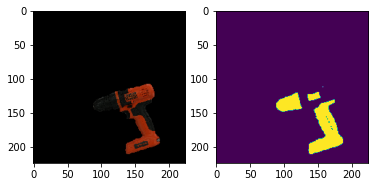

In [21]:
seg_mask = np.zeros_like(masks[0]['segmentation'])
for mask in masks:
    if mask['area'] > int(0.25 * 224 * 224):
        continue
    seg_mask += mask['segmentation']

plt.subplot(1, 2, 1)
plt.imshow(data['samples']['rgb_image'])
plt.subplot(1, 2, 2)
plt.imshow(seg_mask)

In [13]:
for mask in masks:
    print(mask['bbox'], mask['segmentation'].shape, mask['area'])    

[0.0, 0.0, 223.0, 223.0] (224, 224) 45503
[134.0, 120.0, 18.0, 12.0] (224, 224) 168
[148.0, 192.0, 20.0, 10.0] (224, 224) 134
[88.0, 121.0, 37.0, 27.0] (224, 224) 706
[135.0, 112.0, 50.0, 98.0] (224, 224) 1354
[143.0, 131.0, 34.0, 45.0] (224, 224) 610
[135.0, 154.0, 50.0, 56.0] (224, 224) 1344


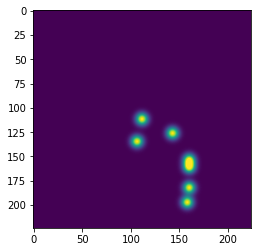

In [24]:
def generate_gaussian_heatmap(center, shape, sigma):
    x = np.arange(0, shape[1], 1, float)  # 从0到width的数列
    y = np.arange(0, shape[0], 1, float)[:, np.newaxis]  # 从0到height的数列
    x0, y0 = center
    heatmap = np.exp(-4*np.log(2) * ((x - x0)**2 + (y - y0)**2) / sigma**2)
    return heatmap

def generate_heatmap_image(image_shape, boxes, sigma=10):
    heatmap = np.zeros(image_shape, dtype=np.float32)
    
    for box in boxes:
        x1, y1, w, h = box
        center = (x1 + w / 2, y1 + h / 2)  # 计算中心点坐标
        heatmap += generate_gaussian_heatmap(center, image_shape, sigma)
    
    heatmap = np.clip(heatmap, 0, 1)
    return heatmap

# 示例图像形状
image_shape = (224, 224)

# 给定的点
points = []
for mask in masks:
    x, y, w, h = np.array(mask['bbox']).astype(int)
    points.append([x,y,w,h])

# 生成热力图
heatmap = generate_heatmap_image(image_shape, points, sigma=10)
plt.imshow(heatmap)

pybullet build time: Jun  6 2024 15:21:23
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


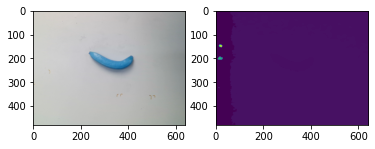

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scripts.utils import reconstruct_heightmaps
from env.env_collect import Environment

env = Environment(gui=False)
env.reset()

def get_heightmap_from_real_image(color, depth, env):
    # Reconstruct real orthographic projection from point clouds.
    hmaps, cmaps = reconstruct_heightmaps(
        [color], [depth], env.oracle_cams, env.bounds, env.pixel_size
    )

    # Split color back into color and masks.
    cmap = np.uint8(cmaps)[0, Ellipsis, :3]
    hmap = np.float32(hmaps)[0, Ellipsis]
    mask = np.uint8(cmaps)[0, Ellipsis, 3:].squeeze()

    return cmap, hmap, mask

rgb_depth_images = np.load('assets/rgb_depth_images.npz')
rgb_image = rgb_depth_images['rgb']
depth_image = rgb_depth_images['depth']

cmap, hmap, mask = get_heightmap_from_real_image(rgb_image, depth_image, env)

plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.subplot(1, 2, 2)
plt.imshow(depth_image)

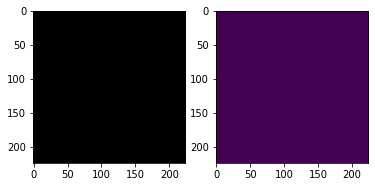

In [3]:
plt.subplot(1, 2, 1)
plt.imshow(cmap)
plt.subplot(1, 2, 2)
plt.imshow(hmap)

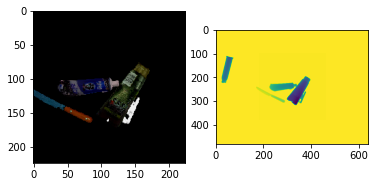

In [2]:
import numpy as np
import matplotlib.pyplot as plt

rgb_depth_images = np.load('assets/pb_rgb_depth.npz')
rgb_image = rgb_depth_images['rgb']
depth_image = rgb_depth_images['depth']


plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.subplot(1, 2, 2)
plt.imshow(depth_image)